In [7]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [4]:
SHORT_SIZE = 10000

(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 28, 28, 1)
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
x_train_mnist = x_train_mnist.astype('float32')
x_test_mnist = x_test_mnist.astype('float32')
x_train_mnist /= 255
x_test_mnist /= 255

(x_train_fmnist, y_train_fmnist), (x_test_fmnist, y_test_fmnist) = tf.keras.datasets.fashion_mnist.load_data()
x_train_fmnist = x_train_fmnist.reshape(x_train_fmnist.shape[0], 28, 28, 1)
x_test_fmnist = x_test_fmnist.reshape(x_test_fmnist.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
x_train_fmnist = x_train_fmnist.astype('float32')
x_test_fmnist = x_test_fmnist.astype('float32')
x_train_fmnist /= 255
x_test_fmnist /= 255

bankdata = pd.read_csv("bill_authentication.csv")
x_bill = bankdata.drop('Class', axis=1)
y_bill = bankdata['Class']
x_train_bill, x_test_bill, y_train_bill, y_test_bill = train_test_split(x_bill, y_bill, test_size = 0.20)

iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_colnames = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
irisdata = pd.read_csv(iris_url, names=iris_colnames)
x_iris = irisdata.drop('Class', axis=1)
y_iris = irisdata['Class']
x_train_iris, x_test_iris, y_train_iris, y_test_iris = train_test_split(x_iris, y_iris, test_size = 0.20)

4423680/4422102 [==============================] - 24s 5us/step


In [5]:
mnist_input_shape = (28, 28, 1)
def create_sequential_model():
    model = Sequential()
    model.add(Conv2D(28, kernel_size=(3,3), input_shape=mnist_input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dropout(0.2))
    model.add(Dense(10,activation=tf.nn.softmax))
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
    return model

def create_linear_svc_model():
    return SVC(kernel='linear',probability=True)

def create_rbf_svc_model():
    return SVC(kernel='rbf',probability=True,gamma='auto')

In [6]:
def query_default(model, x_train, labeled, batch_size, reshape_f):
    res = []
    for i in range(len(x_train)):
        if not labeled[i]:
            res += [i]
        if len(res) == batch_size:
            return res
    return res

def f1(p):
    return 1 - max(p)

def f2(p):
    return 1 - (sorted(p)[-1] - sorted(p)[-2])

def f_entropy(p):
    return -1 * sum([e * math.log((e + math.pow(10, -10))) for e in p])

img_rows = img_cols = 28

def reshape_mnist(x):
    return x.reshape(1, img_rows, img_cols, 1)

def reshape_svc(x):
    return x.reshape(1, -1)

def query_uncert(model, x_train, labeled, batch_size, uncert_f, reshape_f):
    pre_batch = []
    for i in range(len(x_train)):
        if not labeled[i]:
            p = model.predict_proba(reshape_f(x_train[i]))
            pre_batch.append((uncert_f(p.flatten()), i))
    return [i for (p, i) in sorted(pre_batch)[::-1][:batch_size]]

def query_uncert_1(model, x_train, labeled, batch_size, reshape_f):
    return query_uncert(model, x_train, labeled, batch_size, f1, reshape_f)

def query_uncert_2(model, x_train, labeled, batch_size, reshape_f):
    return query_uncert(model, x_train, labeled, batch_size, f2, reshape_f)

def query_entropy(model, x_train, labeled, batch_size, reshape_f):
    return query_uncert(model, x_train, labeled, batch_size, f_entropy, reshape_f)

def score_sequential(model, x_test, y_test):
    return model.evaluate(x_test, y_test, verbose=0)[1]

def score_svc(model, x_test, y_test):
    return model.score(x_test, y_test)

In [29]:
def run_AL(
    query_f, 
    create_model, 
    reshape_f,
    score_f,
    x_train, y_train, x_test, y_test, 
    init_size, batch_size, query_number
):
    x_train, y_train = shuffle(x_train, y_train, random_state=0)
    if len(x_train) > SHORT_SIZE:
        x_train = x_train[:SHORT_SIZE]
    if len(y_train) > SHORT_SIZE:
        y_train = y_train[:SHORT_SIZE]
    x_train_labeled = x_train[:init_size]
    y_train_labeled = y_train[:init_size]
    labeled = [True if i < init_size else False for i in range(x_train.shape[0])]
    
    model = create_model()
    es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=3)
    model.fit(x_train_labeled, y_train_labeled, validation_data=(x_test, y_test), epochs=20, callbacks=[es], verbose=0)

    acc_growth = [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    for i in range(query_number):
        query = query_f(model, x_train, labeled, batch_size, reshape_f)
        for i in query:
            x_train_labeled = np.append(x_train_labeled, [x_train[i]], axis = 0)
            y_train_labeled = np.append(y_train_labeled, [y_train[i]], axis = 0)
            labeled[i] = True
        model.fit(x_train_labeled, y_train_labeled, validation_data=(x_test, y_test), verbose=0)
        acc_growth += [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    return acc_growth

In [31]:
final_stat = {}
final_stat['random'] = {}
final_stat['entropy'] = {}
for init_size in range(500, 5010, 500):
    final_stat['random'][init_size] = []
    final_stat['entropy'][init_size] = []
    for i in range(5):
        random_mnist = run_AL(query_default, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    init_size, 1, 150)
        final_stat['random'][init_size].append(random_mnist)
        entropy_mnist = run_AL(query_entropy, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    init_size, 1, 150)
        final_stat['entropy'][init_size].append(entropy_mnist)

In [32]:
import pickle

with open('final_stat.pkl', 'wb') as f:
    pickle.dump(final_stat, f)

init_size 500


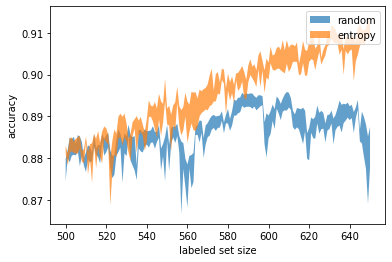

init_size 1000


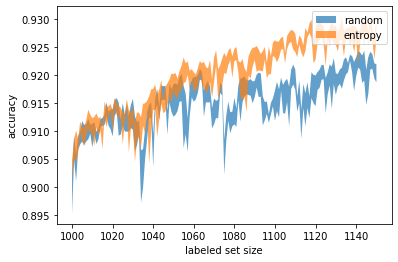

init_size 1500


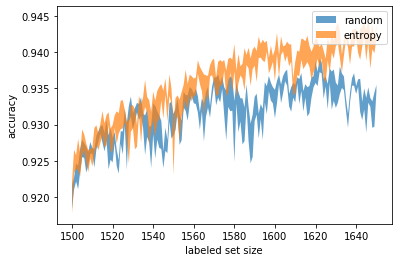

init_size 2000


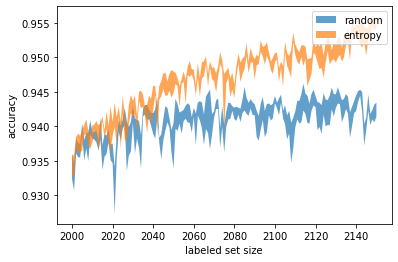

init_size 2500


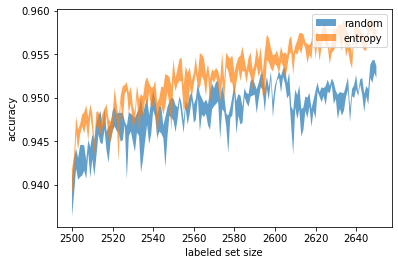

init_size 3000


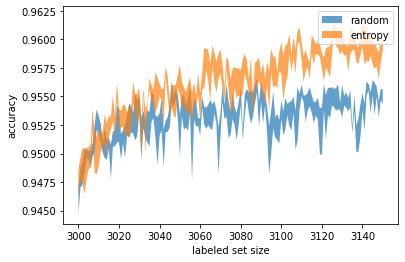

init_size 3500


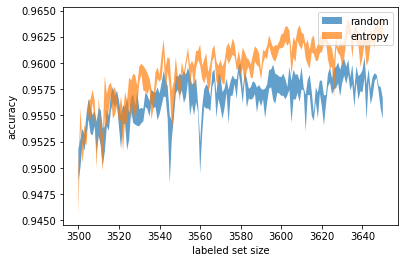

init_size 4000


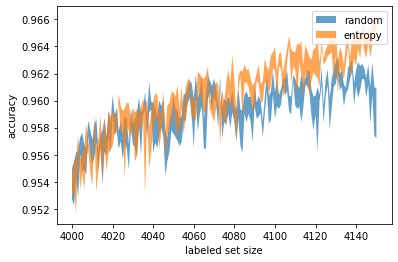

init_size 4500


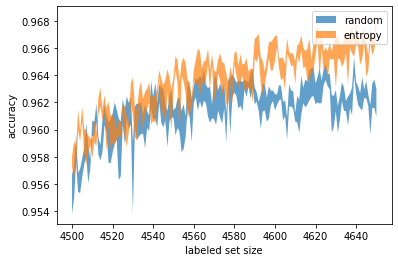

init_size 5000


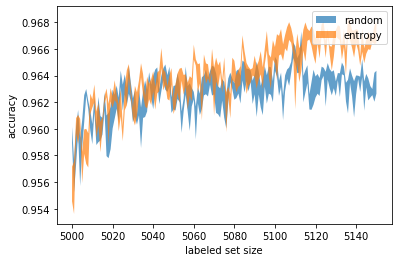

In [43]:
QUERIES = 151
CC = 0.95
N = 5
max_acc = {'random':[], 'entropy':[]}

for init_size in range(500, 5010, 500):
    print('init_size', init_size)
    
    mean_random = [0 for i in range(QUERIES)]
    sum_random_1 = [0 for i in range(QUERIES)]
    sum_random_2 = [0 for i in range(QUERIES)]
    
    mean_entropy = [0 for i in range(QUERIES)]
    sum_entropy_1 = [0 for i in range(QUERIES)]
    sum_entropy_2 = [0 for i in range(QUERIES)]
    
    for i in range(N):
        random_mnist = final_stat['random'][init_size][i]
        random_accurs = [e[1] for e in random_mnist]
        
        entropy_mnist = final_stat['entropy'][init_size][i]
        entropy_accurs = [e[1] for e in entropy_mnist]
        for j in range(QUERIES):
            mean_random[j] += random_accurs[j] / N
            sum_random_1[j] += random_accurs[j] ** 2 / N
            sum_random_2[j] += random_accurs[j] / N
            
            mean_entropy[j] += entropy_accurs[j] / N
            sum_entropy_1[j] += entropy_accurs[j] ** 2 / N
            sum_entropy_2[j] += entropy_accurs[j] / N
            
    max_acc['random'].append(max(mean_random))
    max_acc['entropy'].append(max(mean_entropy))
    
    D_random = [sum_random_1[i] - sum_random_2[i] ** 2 for i in range(QUERIES)]
    D_entropy = [sum_entropy_1[i] - sum_entropy_2[i] ** 2 for i in range(QUERIES)]
    
    sigma_random = [CC * math.sqrt(d) / math.sqrt(N) for d in D_random]
    sigma_entropy = [CC * math.sqrt(d) / math.sqrt(N) for d in D_entropy]

    plt.fill_between(
        range(init_size, init_size + QUERIES), 
        [e + s for (e, s) in zip(mean_random, sigma_random)],
        [e - s for (e, s) in zip(mean_random, sigma_random)], 
        label='random', 
        alpha=0.7
    )
    plt.fill_between(
        range(init_size, init_size + QUERIES), 
        [e + s for (e, s) in zip(mean_entropy, sigma_entropy)],
        [e - s for (e, s) in zip(mean_entropy, sigma_entropy)], 
        label='entropy', 
        alpha=0.7
    )
    plt.xlabel('labeled set size')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
        

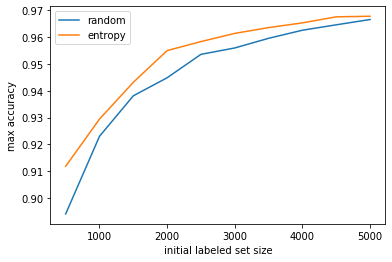

In [44]:
plt.plot(range(500, 5010, 500), max_acc['random'], label='random')
plt.plot(range(500, 5010, 500), max_acc['entropy'], label='entropy')
plt.xlabel('initial labeled set size')
plt.ylabel('max accuracy')
plt.legend()
plt.show()

## Density-Weighted Method
Let's compute center of mass of unlabeled set. Thus we can calculate unsimilarity of one point from others by O(1). Also we can recalculate center of mass after extracting instance simply subtracting vector of choosen instance from vector sum of all unlabeled data instances.

x* (query) will be calculated like **x* = argmax_x (VOI(x) * Unsim(x))** where VOI(x) - informativness, in case below it would be uncertainty, Unsim(x) - distance between **x** and center of mass.

In [48]:
unsim_coef = 0.01

def query_uncert_dwm(model, x_train, labeled, batch_size, uncert_f, reshape_f, mass_center):
    pre_batch = []
    for i in range(len(x_train)):
        if not labeled[i]:
            p = model.predict_proba(reshape_f(x_train[i]))
            unsim = abs(sum(x_train[i].flatten() - mass_center)) ** unsim_coef
            pre_batch.append((uncert_f(p.flatten()) * unsim, i))
    return [i for (p, i) in sorted(pre_batch)[::-1][:batch_size]]

def query_uncert_1_dwm(model, x_train, labeled, batch_size, reshape_f, mass_center):
    return query_uncert_dwm(model, x_train, labeled, batch_size, f1, reshape_f, mass_center)

def query_uncert_2_dwm(model, x_train, labeled, batch_size, reshape_f, mass_center):
    return query_uncert_dwm(model, x_train, labeled, batch_size, f2, reshape_f, mass_center)

def query_entropy_dwm(model, x_train, labeled, batch_size, reshape_f, mass_center):
    return query_uncert_dwm(model, x_train, labeled, batch_size, f_entropy, reshape_f, mass_center)

In [51]:
def run_DWM(
    query_f, 
    create_model, 
    reshape_f,
    score_f,
    x_train, y_train, x_test, y_test, 
    init_size, batch_size, query_number
):
    x_train, y_train = shuffle(x_train, y_train, random_state=0)
    model = create_model()
    x_train_labeled = x_train[:init_size]
    y_train_labeled = y_train[:init_size]
    
    center_vector = np.sum([e.flatten() for e in x_train_labeled], axis=0)
    unlabeled_size = len(x_train) - init_size
    mass_center = center_vector / unlabeled_size
    #print(mass_center)
    labeled = [True if i < init_size else False for i in range(x_train.shape[0])]
    es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=3)
    model.fit(x_train_labeled, y_train_labeled, validation_data=(x_test, y_test), epochs=20, callbacks=[es], verbose=0)

    acc_growth = [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    for i in range(query_number):
        query = query_f(model, x_train, labeled, batch_size, reshape_f, mass_center)
        for i in query:
            x_train_labeled = np.append(x_train_labeled, [x_train[i]], axis = 0)
            y_train_labeled = np.append(y_train_labeled, [y_train[i]], axis = 0)
            labeled[i] = True
            center_vector -= x_train[i].flatten()
        
        unlabeled_size -= batch_size
        mass_center = center_vector / unlabeled_size
        #print(mass_center)
        model.fit(x_train_labeled, y_train_labeled)
        acc_growth += [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    return acc_growth

In [52]:
def run_DWM_labeled(
    query_f, 
    create_model, 
    reshape_f,
    score_f,
    x_train, y_train, x_test, y_test, 
    init_size, batch_size, query_number
):
    x_train, y_train = shuffle(x_train, y_train, random_state=0)
    if len(x_train) > SHORT_SIZE:
        x_train = x_train[:SHORT_SIZE]
    if len(y_train) > SHORT_SIZE:
        y_train = y_train[:SHORT_SIZE]
    model = create_model()
    x_train_labeled = x_train[:init_size]
    y_train_labeled = y_train[:init_size]
    
    center_vector = np.sum([e.flatten() for e in x_train_labeled], axis=0)
    labeled_size =  init_size
    mass_center = center_vector / labeled_size
    labeled = [True if i < init_size else False for i in range(x_train.shape[0])]
    es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=3)
    model.fit(x_train_labeled, y_train_labeled, validation_data=(x_test, y_test), epochs=20, callbacks=[es], verbose=0)

    acc_growth = [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    for i in range(query_number):
        query = query_f(model, x_train, labeled, batch_size, reshape_f, mass_center)
        for i in query:
            x_train_labeled = np.append(x_train_labeled, [x_train[i]], axis = 0)
            y_train_labeled = np.append(y_train_labeled, [y_train[i]], axis = 0)
            labeled[i] = True
            center_vector += x_train[i].flatten()
        
        labeled_size += batch_size
        mass_center = center_vector / labeled_size
        model.fit(x_train_labeled, y_train_labeled)
        acc_growth += [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    return acc_growth

In [55]:
random_mnist = run_AL(query_default, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    2000, 1, 50)
entropy_mnist = run_AL(query_entropy, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    2000, 1, 50)


In [56]:
entropy_mnist_dwm_l = run_DWM_labeled(query_entropy_dwm, create_sequential_model, reshape_mnist, score_sequential, 
                      x_train_mnist, 
                      y_train_mnist, 
                      x_test_mnist, 
                      y_test_mnist,
                      2000, 1, 50)

Epoch 1/1
2001/2001 [==============================] - 1s 605us/step - loss: 0.0104 - accuracy: 0.9980
Epoch 1/1
2002/2002 [==============================] - 1s 554us/step - loss: 0.0185 - accuracy: 0.9965
Epoch 1/1
2003/2003 [==============================] - 1s 728us/step - loss: 0.0143 - accuracy: 0.9955
Epoch 1/1
2004/2004 [==============================] - 1s 613us/step - loss: 0.0174 - accuracy: 0.9975
Epoch 1/1
2005/2005 [==============================] - 1s 637us/step - loss: 0.0154 - accuracy: 0.9980
Epoch 1/1
2006/2006 [==============================] - 1s 564us/step - loss: 0.0097 - accuracy: 0.9990
Epoch 1/1
2007/2007 [==============================] - 1s 567us/step - loss: 0.0088 - accuracy: 0.9980
Epoch 1/1
2008/2008 [==============================] - 1s 534us/step - loss: 0.0115 - accuracy: 0.9960
Epoch 1/1
2009/2009 [==============================] - 1s 583us/step - loss: 0.0099 - accuracy: 0.9975
Epoch 1/1
2010/2010 [==============================] - 1s 578us/step - lo

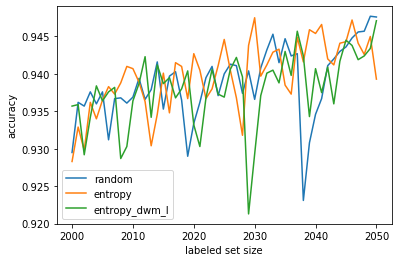

In [57]:
xs_random = [e[0] for e in random_mnist]
ys_random = [e[1] for e in random_mnist]
plt.plot(xs_random, ys_random, label='random')

xs_entropy = [e[0] for e in entropy_mnist]
ys_entropy = [e[1] for e in entropy_mnist]
plt.plot(xs_entropy, ys_entropy, label='entropy')

xs_entropy_dwm = [e[0] for e in entropy_mnist_dwm_l]
ys_entropy_dwm = [e[1] for e in entropy_mnist_dwm_l]
plt.plot(xs_entropy_dwm, ys_entropy_dwm, label='entropy_dwm_l')
plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
entropy_mnist_dwm = run_DWM(query_entropy_dwm, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    2000, 1, 100)

In [26]:
import pickle

file = open('seq_statistic.pkl', 'rb')
seq_statistic = pickle.load(file)


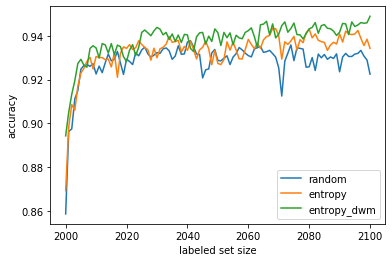

In [27]:
xs_random = [e[0] for e in seq_statistic[0][2]]
ys_random = [e[1] for e in seq_statistic[0][2]]
plt.plot(xs_random, ys_random, label='random')

xs_entropy = [e[0] for e in seq_statistic[1][2]]
ys_entropy = [e[1] for e in seq_statistic[1][2]]
plt.plot(xs_entropy, ys_entropy, label='entropy')

xs_entropy_dwm = [e[0] for e in entropy_mnist_dwm]
ys_entropy_dwm = [e[1] for e in entropy_mnist_dwm]
plt.plot(xs_entropy_dwm, ys_entropy_dwm, label='entropy_dwm')
plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Experiments with different batch sizes

In [59]:
INIT_SIZE = 2000
QUERIES = 100
N = 5

batch_stat = {}
batch_stat['entropy'] = {}
for batch_size in [3, 5, 10, 20]:
    batch_stat['entropy'][batch_size] = []
    for i in range(N):
        entropy_mnist = run_AL(query_entropy, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    INIT_SIZE, batch_size, QUERIES)
        batch_stat['entropy'][batch_size].append(entropy_mnist)

In [60]:
with open('batch_stat.pkl', 'wb') as f:
    pickle.dump(batch_stat, f)

In [61]:
batch_stat['random'] = {}
for batch_size in [3, 5, 10, 20]:
    batch_stat['random'][batch_size] = []
    for i in range(N):
        random_mnist = run_AL(query_default, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    INIT_SIZE, batch_size, QUERIES)
        batch_stat['random'][batch_size].append(random_mnist)

batch_size 3


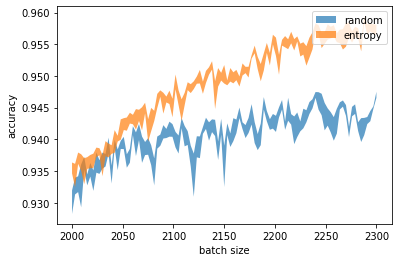

batch_size 5


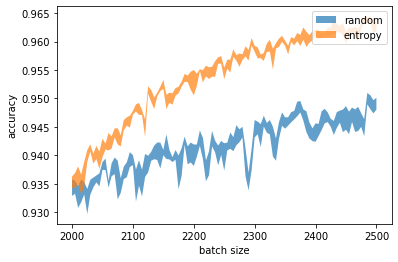

batch_size 10


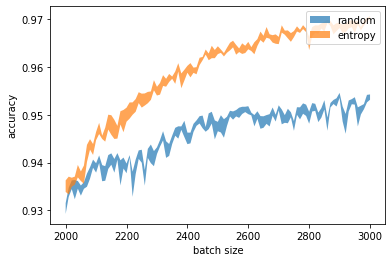

batch_size 20


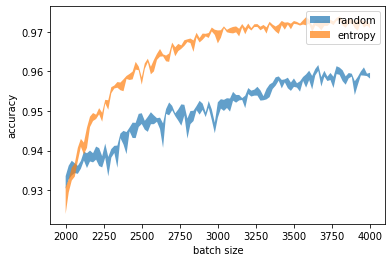

In [65]:
max_acc_batch = {'random':[], 'entropy':[]}


for batch_size in [3, 5, 10, 20]:
    print('batch_size', batch_size)
    
    mean_random = [0 for i in range(QUERIES + 1)]
    sum_random_1 = [0 for i in range(QUERIES + 1)]
    sum_random_2 = [0 for i in range(QUERIES + 1)]
    
    mean_entropy = [0 for i in range(QUERIES + 1)]
    sum_entropy_1 = [0 for i in range(QUERIES + 1)]
    sum_entropy_2 = [0 for i in range(QUERIES + 1)]
    
    for i in range(N):
        random_mnist = batch_stat['random'][batch_size][i]
        random_accurs = [e[1] for e in random_mnist]
        
        entropy_mnist = batch_stat['entropy'][batch_size][i]
        entropy_accurs = [e[1] for e in entropy_mnist]
        for j in range(QUERIES + 1):
            mean_random[j] += random_accurs[j] / N
            sum_random_1[j] += random_accurs[j] ** 2 / N
            sum_random_2[j] += random_accurs[j] / N
            
            mean_entropy[j] += entropy_accurs[j] / N
            sum_entropy_1[j] += entropy_accurs[j] ** 2 / N
            sum_entropy_2[j] += entropy_accurs[j] / N
            
    max_acc_batch['random'].append(max(mean_random))
    max_acc_batch['entropy'].append(max(mean_entropy))
    
    D_random = [sum_random_1[i] - sum_random_2[i] ** 2 for i in range(QUERIES + 1)]
    D_entropy = [sum_entropy_1[i] - sum_entropy_2[i] ** 2 for i in range(QUERIES + 1)]
    
    sigma_random = [CC * math.sqrt(d) / math.sqrt(N) for d in D_random]
    sigma_entropy = [CC * math.sqrt(d) / math.sqrt(N) for d in D_entropy]
    plt.fill_between(
        range(INIT_SIZE,  INIT_SIZE + batch_size*QUERIES + 1, batch_size), 
        [e + s for (e, s) in zip(mean_random, sigma_random)],
        [e - s for (e, s) in zip(mean_random, sigma_random)], 
        label='random', 
        alpha=0.7
    )
    plt.fill_between(
        range(INIT_SIZE, INIT_SIZE + batch_size*QUERIES + 1, batch_size), 
        [e + s for (e, s) in zip(mean_entropy, sigma_entropy)],
        [e - s for (e, s) in zip(mean_entropy, sigma_entropy)], 
        label='entropy', 
        alpha=0.7
    )
    plt.xlabel('batch size')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

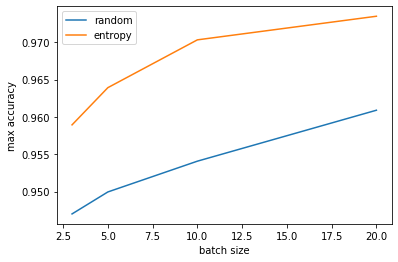

In [66]:
plt.plot([3, 5, 10, 20], max_acc_batch['random'], label='random')
plt.plot([3, 5, 10, 20], max_acc_batch['entropy'], label='entropy')
plt.xlabel('batch size')
plt.ylabel('max accuracy')
plt.legend()
plt.show()

## Autoencoder

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 69us/step - loss: 0.3615 - val_loss: 0.2714
Epoch 2/50
60000/60000 [==============================] - 4s 63us/step - loss: 0.2641 - val_loss: 0.2530
Epoch 3/50
60000/60000 [==============================] - 4s 65us/step - loss: 0.2417 - val_loss: 0.2282
Epoch 4/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.2204 - val_loss: 0.2103
Epoch 5/50
60000/60000 [==============================] - 4s 62us/step - loss: 0.2055 - val_loss: 0.1981
Epoch 6/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.1951 - val_loss: 0.1893
Epoch 7/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1873 - val_loss: 0.1823
Epoch 8/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.1807 - val_loss: 0.1761
Epoch 9/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.1748 - val_loss: 0.1705
Epoch

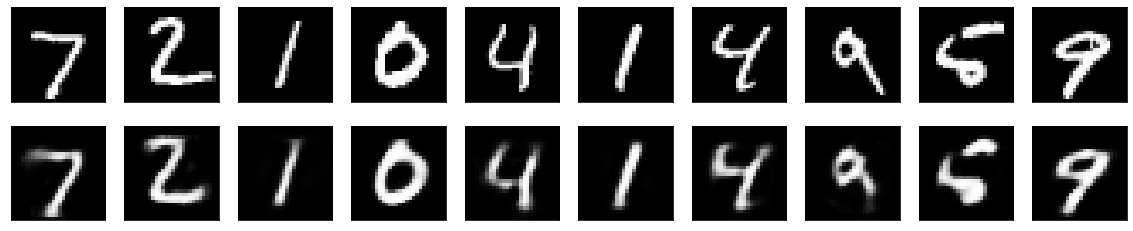

In [86]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
from keras.datasets import mnist
import numpy as np

x_train_mnist_reshaped = x_train_mnist.reshape((len(x_train_mnist), np.prod(x_train_mnist.shape[1:])))
x_test_mnist_reshaped = x_test_mnist.reshape((len(x_test_mnist), np.prod(x_test_mnist.shape[1:])))
autoencoder.fit(x_train_mnist_reshaped, x_train_mnist_reshaped,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_mnist_reshaped, x_test_mnist_reshaped))

encoded_imgs = encoder.predict(x_test_mnist_reshaped)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_mnist_reshaped[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [88]:
seq_model = create_sequential_model()

[ 2.6433923  5.875567   3.9899936  1.6772424 15.720315  10.529435
  2.717591   3.8323147  0.         5.134446   7.5840425  8.955069
  2.3333492  6.509052   1.0020188  3.9807286  0.         6.5994983
  7.5970435 15.707709   5.7975154  2.644144   3.0798995  3.649339
  9.528528   6.2796474  2.1230054  6.2162848  5.7385464  8.261792
  3.0808632  3.8099556]


## SBC

In [151]:
def default_init(x, init_size):
    return [True if i < init_size else False for i in range(len(x))]

from sklearn.cluster import AgglomerativeClustering

def cluster_init(x, init_size):
    x = [e.flatten() for e in x]
    clustering = AgglomerativeClustering(n_clusters=init_size).fit(x)
    vec_sums = [np.zeros(len(x[0])) for j in range(init_size)]
    vec_nums = [0.0 for j in range(init_size)]
    for i in range(len(x)):
        vec_sums[clustering.labels_[i]] = np.add(vec_sums[clustering.labels_[i]], x[i])
        vec_nums[clustering.labels_[i]] += 1

    centers = [a / b for (a, b) in zip(vec_sums, vec_nums)]
    closest = [None for _ in range(init_size)]
    for i in range(len(x)):
        label = clustering.labels_[i]
        d = np.linalg.norm(x[i] - centers[label])
        if closest[label] == None or d < closest[label][1]:
            closest[label] = (i, d)
            
    is_init = [False for _ in range(len(x))]
    for c in closest:
        is_init[c[0]] = True
    return is_init

In [152]:
def run_AL_SBC(
    query_f, 
    create_model, 
    reshape_f,
    score_f,
    x_train, y_train, x_test, y_test, 
    init_size, batch_size, query_number
):
    x_train, y_train = shuffle(x_train, y_train, random_state=0)
    if len(x_train) > SHORT_SIZE:
        x_train = x_train[:SHORT_SIZE]
    if len(y_train) > SHORT_SIZE:
        y_train = y_train[:SHORT_SIZE]
    
    x_train_reshaped = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_encoded = encoder.predict(x_train_reshaped)
    labeled = cluster_init(x_encoded, init_size)
    x_train_labeled = np.array([x_train[i] for i in range(len(x_train)) if labeled[i]])
    y_train_labeled = np.array([y_train[i] for i in range(len(y_train)) if labeled[i]])
    model = create_model()
    es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=3)
    model.fit(x_train_labeled, y_train_labeled, validation_data=(x_test, y_test), epochs=20, callbacks=[es], verbose=0)
    acc_growth = [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    for i in range(query_number):
        query = query_f(model, x_train, labeled, batch_size, reshape_f)
        for i in query:
            x_train_labeled = np.append(x_train_labeled, [x_train[i]], axis = 0)
            y_train_labeled = np.append(y_train_labeled, [y_train[i]], axis = 0)
            labeled[i] = True
        model.fit(x_train_labeled, y_train_labeled, validation_data=(x_test, y_test), verbose=0)
        acc_growth += [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    return acc_growth

In [ ]:
entropy_sbc_mnist = run_AL_SBC(query_entropy, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    2000, 1, 150)

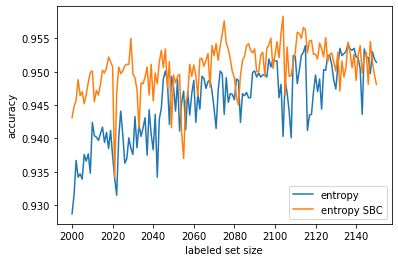

In [149]:
xs_entropy = [e[0] for e in final_stat['entropy'][2000][0]]
ys_entropy = [e[1] for e in final_stat['entropy'][2000][0]]
plt.plot(xs_entropy, ys_entropy, label='entropy')

xs_entropy_sbc = [e[0] for e in entropy_sbc_mnist]
ys_entropy_sbc = [e[1] for e in entropy_sbc_mnist]
plt.plot(xs_entropy_sbc, ys_entropy_sbc, label='entropy SBC')

plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [166]:
sbc_stat = []
for i in range(5):
    sbc_stat.append(run_AL_SBC(query_entropy, create_sequential_model, reshape_mnist, score_sequential, 
                        x_train_mnist, 
                        y_train_mnist, 
                        x_test_mnist, 
                        y_test_mnist,
                        2000, 1, 150))

In [167]:
with open('sbc_stat.pkl', 'wb') as f:
    pickle.dump(sbc_stat, f)

## SUD

In [153]:
def query_uncert_sub(model, x_train, labeled, batch_size, uncert_f, reshape_f, mass_center):
    pre_batch = []
    for i in range(len(x_train)):
        if not labeled[i]:
            p = model.predict_proba(reshape_f(x_train[i]))
            sim = 1 / np.linalg.norm(x_train[i] - mass_center)
            pre_batch.append((uncert_f(p.flatten()) * sim, i))
    return [i for (p, i) in sorted(pre_batch)[::-1][:batch_size]]

def query_uncert_1_sub(model, x_train, labeled, batch_size, reshape_f, mass_center):
    return query_uncert_dwm(model, x_train, labeled, batch_size, f1, reshape_f, mass_center)

def query_uncert_2_sub(model, x_train, labeled, batch_size, reshape_f, mass_center):
    return query_uncert_dwm(model, x_train, labeled, batch_size, f2, reshape_f, mass_center)

def query_entropy_sub(model, x_train, labeled, batch_size, reshape_f, mass_center):
    return query_uncert_dwm(model, x_train, labeled, batch_size, f_entropy, reshape_f, mass_center)

In [154]:
def run_AL_SUD(
    query_f, 
    create_model, 
    reshape_f,
    score_f,
    x_train, y_train, x_test, y_test, 
    init_size, batch_size, query_number
):
    x_train, y_train = shuffle(x_train, y_train, random_state=0)
    if len(x_train) > SHORT_SIZE:
        x_train = x_train[:SHORT_SIZE]
    if len(y_train) > SHORT_SIZE:
        y_train = y_train[:SHORT_SIZE]
    
    labeled = default_init(x_train, init_size)
    x_train_labeled = np.array([x_train[i] for i in range(len(x_train)) if labeled[i]])
    y_train_labeled = np.array([y_train[i] for i in range(len(y_train)) if labeled[i]])
    
    model = create_model()
    es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=3)
    model.fit(x_train_labeled, y_train_labeled, validation_data=(x_test, y_test), epochs=20, callbacks=[es], verbose=0)

    center_vector = np.sum([x_train[i].flatten() for i in range(len(x_train)) if not labeled[i]], axis=0)
    unlabeled_size =  len(x_train) - init_size
    mass_center = center_vector / unlabeled_size
    
    acc_growth = [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    for i in range(query_number):
        query = query_f(model, x_train, labeled, batch_size, reshape_f, mass_center)
        for i in query:
            x_train_labeled = np.append(x_train_labeled, [x_train[i]], axis = 0)
            y_train_labeled = np.append(y_train_labeled, [y_train[i]], axis = 0)
            labeled[i] = True
            center_vector -= x_train[i].flatten()
        unlabeled_size -= batch_size
        mass_center = center_vector / unlabeled_size
        model.fit(x_train_labeled, y_train_labeled, validation_data=(x_test, y_test), verbose=0)
        acc_growth += [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    return acc_growth

In [158]:
entropy_sub_mnist = run_AL_SUD(query_entropy_sub, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    2000, 1, 150)

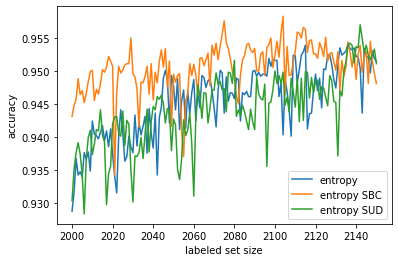

In [159]:
xs_entropy = [e[0] for e in final_stat['entropy'][2000][0]]
ys_entropy = [e[1] for e in final_stat['entropy'][2000][0]]
plt.plot(xs_entropy, ys_entropy, label='entropy')

xs_entropy_sbc = [e[0] for e in entropy_sbc_mnist]
ys_entropy_sbc = [e[1] for e in entropy_sbc_mnist]
plt.plot(xs_entropy_sbc, ys_entropy_sbc, label='entropy SBC')

xs_entropy_sub = [e[0] for e in entropy_sub_mnist]
ys_entropy_sub = [e[1] for e in entropy_sub_mnist]
plt.plot(xs_entropy_sub, ys_entropy_sub, label='entropy SUD')

plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [168]:
sud_stat = []
for i in range(5):
    sud_stat.append(run_AL_SUD(query_entropy_sub, create_sequential_model, reshape_mnist, score_sequential, 
                        x_train_mnist, 
                        y_train_mnist, 
                        x_test_mnist, 
                        y_test_mnist,
                        2000, 1, 150))

In [169]:
with open('sud_stat.pkl', 'wb') as f:
    pickle.dump(sud_stat, f)

## SBC + SUD

In [163]:
def run_AL_SBC_SUD(
    query_f, 
    create_model, 
    reshape_f,
    score_f,
    x_train, y_train, x_test, y_test, 
    init_size, batch_size, query_number
):
    x_train, y_train = shuffle(x_train, y_train, random_state=0)
    if len(x_train) > SHORT_SIZE:
        x_train = x_train[:SHORT_SIZE]
    if len(y_train) > SHORT_SIZE:
        y_train = y_train[:SHORT_SIZE]
    
    x_train_reshaped = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_encoded = encoder.predict(x_train_reshaped)
    labeled = cluster_init(x_encoded, init_size)
    x_train_labeled = np.array([x_train[i] for i in range(len(x_train)) if labeled[i]])
    y_train_labeled = np.array([y_train[i] for i in range(len(y_train)) if labeled[i]])
    
    model = create_model()
    es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=3)
    model.fit(x_train_labeled, y_train_labeled, validation_data=(x_test, y_test), epochs=20, callbacks=[es], verbose=0)

    center_vector = np.sum([x_train[i].flatten() for i in range(len(x_train)) if not labeled[i]], axis=0)
    unlabeled_size =  len(x_train) - init_size
    mass_center = center_vector / unlabeled_size
    
    acc_growth = [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    for i in range(query_number):
        query = query_f(model, x_train, labeled, batch_size, reshape_f, mass_center)
        for i in query:
            x_train_labeled = np.append(x_train_labeled, [x_train[i]], axis = 0)
            y_train_labeled = np.append(y_train_labeled, [y_train[i]], axis = 0)
            labeled[i] = True
            center_vector -= x_train[i].flatten()
        unlabeled_size -= batch_size
        mass_center = center_vector / unlabeled_size
        model.fit(x_train_labeled, y_train_labeled, validation_data=(x_test, y_test), verbose=0)
        acc_growth += [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    return acc_growth

In [164]:
entropy_sbc_sub_mnist = run_AL_SBC_SUD(query_entropy_sub, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    2000, 1, 150)

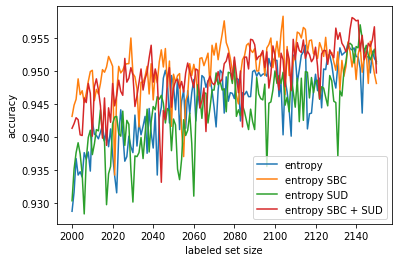

In [165]:
xs_entropy = [e[0] for e in final_stat['entropy'][2000][0]]
ys_entropy = [e[1] for e in final_stat['entropy'][2000][0]]
plt.plot(xs_entropy, ys_entropy, label='entropy')

xs_entropy_sbc = [e[0] for e in entropy_sbc_mnist]
ys_entropy_sbc = [e[1] for e in entropy_sbc_mnist]
plt.plot(xs_entropy_sbc, ys_entropy_sbc, label='entropy SBC')

xs_entropy_sub = [e[0] for e in entropy_sub_mnist]
ys_entropy_sub = [e[1] for e in entropy_sub_mnist]
plt.plot(xs_entropy_sub, ys_entropy_sub, label='entropy SUD')

xs_entropy_sbc_sud = [e[0] for e in entropy_sbc_sub_mnist]
ys_entropy_sbc_sud = [e[1] for e in entropy_sbc_sub_mnist]
plt.plot(xs_entropy_sbc_sud, ys_entropy_sbc_sud, label='entropy SBC + SUD')

plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [170]:
sbc_sud_stat = []
for i in range(5):
    sbc_sud_stat.append(run_AL_SBC_SUD(query_entropy_sub, create_sequential_model, reshape_mnist, score_sequential, 
                        x_train_mnist, 
                        y_train_mnist, 
                        x_test_mnist, 
                        y_test_mnist,
                        2000, 1, 150))

In [171]:
with open('sbc_sud_stat.pkl', 'wb') as f:
    pickle.dump(sbc_sud_stat, f)

In [176]:
def plot_conf_int(stat, stat_name):
    if len(stat) == 0:
        return
    q = len(stat[0])
    mean = [0 for i in range(q)]
    sum_1 = [0 for i in range(q)]
    sum_2 = [0 for i in range(q)]
    
    for i in range(len(stat)):
        accurs = [e[1] for e in stat[i]]
        for j in range(q):
            mean[j] += accurs[j] / N
            sum_1[j] += accurs[j] ** 2 / N
            sum_2[j] += accurs[j] / N
                
    D = [sum_1[i] - sum_2[i] ** 2 for i in range(q)]
    sigma = [CC * math.sqrt(d) / math.sqrt(N) for d in D]
    
    plt.fill_between(
        range(stat[0][0][0], stat[0][-1][0] + 1, stat[0][1][0] - stat[0][0][0]), 
        [m + s for (m, s) in zip(mean, sigma)],
        [m - s for (m, s) in zip(mean, sigma)], 
        label=stat_name, 
        alpha=0.7
    )
    

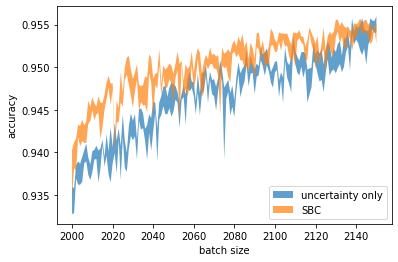

In [181]:
plot_conf_int(final_stat['entropy'][2000], "uncertainty only")
plot_conf_int(sbc_stat, "SBC")
#plot_conf_int(sud_stat, "SUD")
#plot_conf_int(sbc_sud_stat, "SBC + SUD")
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()